## Data_Visualization_EIS.ipynb
#### Analyzes EIS Data from Big Kahuna for Convenient Feedback.
##### Miles Smith
##### 19 September 2023

In [1]:
import glob
import os
import math
import statistics
import matplotlib.pyplot as plt
import numpy as np
from impedance import preprocessing
from impedance.models.circuits import CustomCircuit
# Note that altair was downgraded to v3.0 for impedance.
from impedance.visualization import plot_nyquist, plot_residuals
from impedance.validation import linKK

###  To-Do
Parse sample number, temperature from path string

### Configure User Inputs

In [11]:
# Set the directory path to where the data files (*.txt) format are located on the computer
# directory_path = '/Users/milessmith/Documents/GitHub/mit-tri-robot/eis_sample_data' # Miles MacBook Pro (for testing)
directory_path = 'C:\\Users\miles\Documents\GitHub\mit-tri-robot\eis_sample_data'
# directory_path = 'C:\EIS' # Unchained Labs computer USE THIS DIRECTORY PATH IN 6-020

# Do you want to filter out bad data?
data_filter_selection = 1 # 1 = yes / 0 = no
# If yes, I use the expected value of the residuals compared to a model to determine if the data is adequate.
# What should the threshold be to flag data?
avg_residuals_cutoff = 0.05

# Select equivalent circuit model
user_circuit = 'R0-p(R2-Wo1,C2)'
# Initial guess of parameter values for ECM. From my observations this is a bit finnicky. 
user_guess = [10**4, 10**5, 10**5, 10**-1, 10**-10]

# Do you want multiple plots or each data array to be overlapped on each other?
overlay_data = 1  # 1 = yes | 0 = no

# Do you want to save the figures generated?
save_main_fig = 1 # 1 = yes | 0 = no


### Select Data files

In [12]:
'''
Example File structure: 103965_5_20230918_073125_25.txt
Plate Number: 103965
Vial Number (?): 5
Date: 20230918
Vial Code (?): 073125
Temperature (degC): 25
'''

### NOTICE: The underscores are an important aspect of the strings for temp and vial number. ###
# plate_number = '103965_'
plate_number = "skip"

# vial_number = '_5_' # YOU CAN FILTER BY VIAL NUMBER
vial_number = "skip"

# NOTE: Some of the dates are incorrect, so it might be good to configure the code to look at two dates. 
date1 = '_20230918_' # PICK THE DATE OF THE SAMPLE YOU ARE INTERESTED
# date1 = "skip"
date2 = '_20230917_'
# date2 = "skip"

temperature = '_25' # YOU CAN FILTER BY TEMPERATURE
# temperature = "skip"

### Frequency Range

The text (.txt) does not include the frequency, so I am manually importing this from a .mpt file. 
If we adjust the frequency range, then we will need to adjust this, but from my observations we always sample
using the same frequencies. This could be subject to change if we ever changed the scan rate, so it is
important to be mindful!

FYI: This specific frequency array probably only works as long as we are using a scan frequency of 0.2. 

In [13]:
# Note: Freq[Hz]
frequency = [ 6999984, 5969734, 5091109, 4341796, 3702781, 3157797, 2693047, 2296687, 1958656,1670375,
             1424531,1214875,1036062,883578.100000000,753531.200000000,642624.900000000,548046.800000000, 
             467390.600000000, 398593.700000000, 339937.500000000, 289906.200000000, 247234.400000000, 
             210843.700000000, 179812.500000000, 153343.800000000, 130781.200000000, 111531.300000000,  
             95109.3700000000, 81109.3700000000, 69171.8800000000, 59000, 50312.5000000000, 42906.2500000000, 
             36593.7500000000, 31203.1300000000, 26609.3800000000, 22703.1300000000, 19359.3700000000,  
             16500, 14112.0200000000, 12011.1300000000, 10236.3800000000, 8750.68400000000, 7449.46300000000, 
             6363.20600000000, 5414.76100000000, 4620.56700000000, 3941.21500000000, 3361.76900000000, 
             2867.24400000000, 2442.65800000000, 2083.00300000000, 1777.84300000000, 1513.54800000000, 
             1292.06500000000, 1101.76200000000, 939.101000000000, 801.280100000000, 684.343300000000, 
             582.947600000000, 497.067700000000, 423.508900000000, 361.503600000000, 308.126200000000, 
             262.729800000000, 224.211100000000, 191.285400000000, 163.172200000000, 139.153700000000, 
             118.670600000000, 101.198200000000, 86.2419600000000, 73.6102400000000, 62.6929100000000, 
             53.5769700000000, 45.6574600000000, 38.9651200000000, 33.1841400000000, 28.3061700000000, 
             24.1723700000000, 20.6134500000000, 17.5561800000000, 14.9855800000000, 12.7655300000000, 
             10.8809000000000, 9.27850500000000, 7.92339400000000, 6.75822000000000, 5.76142900000000, 
             4.91970800000000, 4.19125700000000, 3.56409700000000, 3.05175800000000, 2.60416400000000, 
             2.21442400000000, 1.89256700000000, 1.60750700000000, 1.37641300000000, 1.17375000000000, 
             1.00160400000000 ]

for i in range(len(frequency)):
    frequency[i] = np.int32(frequency[i])

f = np.array(frequency)
    

### Downsize dataset to only the files of interest

In [14]:
### Read in all file names in EIS folder ###

# Specify the directory path and file extension pattern
extension_pattern = '*.txt'  # List .txt files, for example

# Get a list of file names matching the pattern in the directory
path_names = glob.glob(os.path.join(directory_path, extension_pattern))

# New list to append the files of interest
useful_path = []
for path in path_names:
    if (date1 in path) or (date1 == "skip") or (date2 in path) or (date2 == "skip"):
        if (vial_number in path) or (vial_number == "skip"):
            if (temperature in path) or (temperature == "skip"):
                if (plate_number in path) or (plate_number == "skip"):
                    useful_path.append(path)

print("Number of files selected: " + str(len(useful_path)))

Number of files selected: 15


### Data Import, Basic Analysis, and Figures
Here I imported the data from the system and did basic calculations for further analysis.


C:\Users\miles\anaconda3\Lib\site-packages\impedance\validation.py:306: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - neg_sum/pos_sum


[XX] High residuals in:  C:\Users\miles\Documents\GitHub\mit-tri-robot\eis_sample_data\103965_10_20230918_102349_25.txt
10 0.977252749774679 14563.094511747835
[!!] Residuals are good in:  C:\Users\miles\Documents\GitHub\mit-tri-robot\eis_sample_data\103965_11_20230918_103756_25.txt
10 0.9819240077993463 49742.965536417825
[!!] Residuals are good in:  C:\Users\miles\Documents\GitHub\mit-tri-robot\eis_sample_data\103965_12_20230918_112509_25.txt
10 0.9999902474553345 101017.34104025943
[!!] Residuals are good in:  C:\Users\miles\Documents\GitHub\mit-tri-robot\eis_sample_data\103965_13_20230918_123557_25.txt
[XX] High residuals in:  C:\Users\miles\Documents\GitHub\mit-tri-robot\eis_sample_data\103965_14_20230918_132402_25.txt
[XX] High residuals in:  C:\Users\miles\Documents\GitHub\mit-tri-robot\eis_sample_data\103965_15_20230918_133218_25.txt
10 0.9999941424642796 272170.66343379935
[XX] High residuals in:  C:\Users\miles\Documents\GitHub\mit-tri-robot\eis_sample_data\103965_1_20230917_

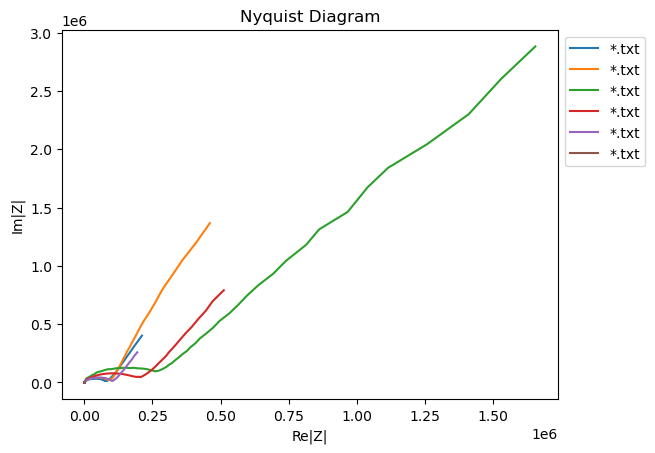

In [18]:
'''
Open and manage data from .txt files
'''
    
bad_data = 0
good_data = 0

for path in useful_path:
    
    # Open the file for reading
    with open(path, 'r') as file:
        
        # Initialize arrays for impedance and conductivity values.
        ReZOhm = []
        ImZOhm = []
        conductivity = []
        i = 0
                
        # Parse each line in the .txt files to the correct array.
        for line in file:
            ZOhm_Values = line.split()
            ReZOhm.append(float(ZOhm_Values[0]))
            ImZOhm.append(float(ZOhm_Values[1]))
            
            # resistivity = resistance (ReZ) * area / length
            # where area = cross-sectional area, length = distance between electrodes
            # These should eventually move to the header tab for user parameters
            diameter = 0.010 # [m] User-input required here
            length = 0.0001 # [m] # User-input
            area = math.pi*diameter**2/4
            # Setting A and l to 1 makes this just conductance
            # area = 1
            # length = 1 
            resistivity = ReZOhm[i] * (area) / length
            conductivity.append(1/resistivity)
            i += 1
            
        ZOhm = []
        ZVector = []
        ZPhase = []
        for i in range(len(ReZOhm)):
            Z_temp = ReZOhm[i] - 1j*ImZOhm[i] # Rearrange into format of array. 
            ZOhm.append(Z_temp)
            ZVector.append(math.sqrt(ReZOhm[i]**2+ImZOhm[i]**2))
            ZPhase.append(math.atan(ImZOhm[i]/ReZOhm[i])*180/math.pi) # Phase in degrees = atan(Im|Z|/Re|Z|)
            
        Z = np.array(ZOhm)
        
        # Create a linear Kronigs-Kramer model to fit data
        try:
            M, mu, Z_linKK, res_real, res_imag = linKK(f, Z, c=.85, max_M=100, fit_type='complex', add_cap=True)
        except:
            print("[XX] Data type and structure error in: ", file.name)
            bad_data += 1
            continue

        Re_residuals_avg = statistics.mean(abs(res_real))
        Im_residuals_avg = statistics.mean(abs(res_imag))
        
        if (data_filter_selection == 1):
            bad_data_threshold = avg_residuals_cutoff
        else:
            bad_data_threshold = math.inf
        
        # Use linKK to identify which datasets have large residuals. 
        if Re_residuals_avg > bad_data_threshold or Im_residuals_avg > bad_data_threshold:
            print("[XX] High residuals in: ", file.name)
            bad_data += 1
            continue
        else:
            print("[!!] Residuals are good in: ", file.name)
            good_data += 1
            Z = ZOhm
            
            if (save_main_fig == 1):
                pass
            else:
                circuit = user_circuit
                # Initial guess of parameter values for ECM. From my observations this is a bit finnicky. 
                initial_guess = user_guess
                circuit = CustomCircuit(circuit, initial_guess=initial_guess)
                # Fit data to equivalent circuit model
                circuit.fit(f, Z)
                Z_fit = circuit.predict(f)

                # Create Nyquist Plot
                plt.figure(4)
                modelFig, ax = plt.subplots()
                plot_nyquist(Z, fmt='o', scale=10, ax=ax)
                plot_nyquist(Z_fit, fmt='-', scale=10, ax=ax)
                plot_nyquist(Z_linKK, fmt='-', scale=10, ax=ax)
                plt.legend([path, 'Circuit Model', 'Kronigs-Kramer Model'], bbox_to_anchor=(1, 1))
                modelFig.show()

                # Plot residuals
                plt.figure(5)
                residualFig, ax2 = plt.subplots()
                plot_residuals(ax2, f, res_real, res_imag, y_limits=(-50, 50))
                residualFig.show()
            
        '''
        Make figures 
        '''
        if len(frequency) == len(conductivity):
            '''
            plt.figure(1)
            plt.plot(frequency, conductivity, label = path)
            plt.title('Conductivity as a function of frequency')
            plt.xlabel('Frequency [Hz]')
            plt.ylabel('Conductivity [S/m]')
            plt.legend(bbox_to_anchor=(1, 1))
            # plt.ylim((0, 10))
            '''

            plt.figure(2)
            #plt.loglog(ReZOhm, ImZOhm, label = path) # I know this is unconventional, but it makes it easier to look at multiple lines.
            plt.plot(ReZOhm, ImZOhm, label = path)
            # plt.plot(np.real(Z_linKK), -np.imag(Z_linKK), linestyle = '--', label = path)
            plt.title('Nyquist Diagram')
            plt.xlabel('Re|Z|')
            plt.ylabel('Im|Z|')
            plt.legend(bbox_to_anchor=(1, 1))
            # plt.xlim((0, 250000))
            # plt.ylim((0, 100000))
            
            '''
            plt.figure(3)
            fig, ax1 = plt.subplots()
            plt.title('Bode Plot: Magnitude and Phase as a function of Frequency')
            color = 'tab:blue'
            ax1.set_xlabel('Frequency [Hz]')
            ax1.set_ylabel('Magnitude', color=color)
            ax1.loglog(frequency, ZVector, label = path)
            ax1.tick_params(axis='y', labelcolor=color)

            ax2 = ax1.twinx()
            color = 'tab:red'
            ax2.set_ylabel('Phase', color=color)  # we already handled the x-label with ax1
            ax2.loglog(frequency, ZPhase, color = color)
            ax2.tick_params(axis='y', labelcolor=color)
            '''

        else:
            print("Dimensionality Error in file:" + path + "\nLength of Conductivity Array:" + str(len(conductivity)))

print("Number of Adequate Data Files: ", good_data, "| Number of Poor Data Files: ", bad_data, "| Total Number of Files: ", good_data+bad_data)

if (save_main_fig == 1):
    plt.savefig(directory_path+'_mainfigure.png')


### Implement Kramers-Kronig Relations for Data Validation
Kramers-Kronig relations work by predicting the real component of a complex number based off of the complex value and the vice versa. In theory this works if the relationships are causal and analytical. 

In [12]:
    # Create ECM and fit to the data collected
    circuit = CustomCircuit(circuit, initial_guess=initial_guess)
    ### The impedance.py documentation uses a much higher order ECM to fit the data, might be worth a try if this doesn't work at first.

        
    # Z = ZOhm
    
    # mask = f < 1000
    # f = f[mask]
    # Z = Z[mask]
    # f, Z = preprocessing.ignoreBelowX(f, Z)
    ### -- Still needs to be understood better! -- ###
    # Fit data to equivalent circuit model
    circuit.fit(f, Z)
    # print(circuit)
    Z_fit = circuit.predict(f)

    # Create Nyquist Plot
    plt.figure(3)
    fig, ax = plt.subplots()
    plot_nyquist(Z, fmt='o', scale=10, ax=ax)
    plot_nyquist(Z_fit, fmt='-', scale=10, ax=ax)
    plot_nyquist(Z_linKK, fmt='-', scale=10, ax=ax)


    plt.legend([path, 'Circuit Model', 'Kronigs-Kramer Model'], bbox_to_anchor=(1, 1))
    
    
    # Plot residuals
    plt.figure(4)
    fig2, ax2 = plt.subplots()
    plot_residuals(ax2, f, res_real, res_imag, y_limits=(-50, 50))


NameError: name 'circuit' is not defined